## Jabari Crenshaw
#### CSC 180, Intellgent Systems
#### Prof. Chen
#### Project 1

### 0. Imports
We will begin by doing some necessary import statements, and including a function we will use to plot our model lift chart.

In [4]:
import os
import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from sklearn import metrics
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show

from collections.abc import Sequence

path = "./data/"

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

### 1. Reading Review CSV data
##### We will first read all the data we have for reviews. We will also remove attributes of reviews that are not useful for this project.

In [9]:
review_data = os.path.join(path, 'yelp_academic_dataset_review.csv')
df_review = pd.read_csv(review_data)

df_review.drop(['review_id', 'user_id', 'useful', 'funny', 'cool', 'date'],
    axis=1, inplace=True)

df_review.head()

,business_id,stars,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is..."
1,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...
2,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...
3,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...


### 3. Reading Business CSV data
##### We will read all the data we have for businesses and remove all businesses that have a review count less than 20. We will also remove attributes of businesses that are not useful in this project.

In [7]:
business_data = os.path.join(path, 'yelp_academic_dataset_business.csv')
df_business = pd.read_csv(business_data)

df_business.drop(['address', 'city', 'state', 'postal_code', 'latitude', 'longitude',
    'is_open', 'attributes', 'categories', 'hours'], axis=1, inplace=True)

df_business = df_business[df_business['review_count'] >= 20]

df_business.drop(['review_count'], axis=1, inplace=True)

df_business.head()

,business_id,name,stars
2,tUFrWirKiKi_TAnsVWINQQ,Target,3.5
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,4.0
12,il_Ro8jwPlHresjw9EGmBg,Denny's,2.5
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,4.5
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,4.0


### 4. More preprocessing steps for our model.
##### 1) We create a Pandas Series (df_review_agg) that combines all the reviews of each business.
##### 2) We create another Pandas Series (df_review_average_stars) that is the mean rating value of reviews for each business.
##### 3) We create a Pandas DataFrame (df_ready_for_sklearn) that holds the business_id of all business and the review text sum for each business.

In [11]:
df_review_agg = df_review.groupby('business_id')['text'].sum()
df_review_average_stars = df_review.groupby('business_id')['stars'].mean()

df_ready_for_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                    'all_reviews': df_review_agg.values})

df_review_average_stars.head()
df_ready_for_sklearn.head()

,business_id,all_reviews
0,---kPU91CF4Lq2-WlRu9Lw,Ate here for the 1st time on Saturday 08/07/20...
1,--0iUa4sNDFiZFrAdIWhZQ,Very good San Salvadorian place ! Authentic an...
2,--30_8IhuyMHbSOcNWd6DQ,We stopped going to Action Karate in December ...
3,--7PUidqRWpRSpXebiyxTg,"This place is disgusting, and proof that Edmon..."
4,--7jw19RH9JKXgFohspgQw,"This is the best dentist in the area, hands do..."


### 5. Feature Extraction using TfidfVectorizer.
##### We will use this function to extract feature names from the reviews of all businesses. This function will provide us a list of feature names and the corresponding TF-IDF matrix.

In [13]:
vectorizer = sk_text.TfidfVectorizer(min_df=.1, max_df=.85, stop_words='english',
                    lowercase=True, analyzer='word')

matrix = vectorizer.fit_transform(df_ready_for_sklearn['all_reviews'])

feature_names = vectorizer.get_feature_names
tfidf_data = matrix.toarray()

feature_names

tfidf_data
tfidf_data.shape

(150346, 1576)

### 6. Model Creation
##### At this point, we have evverything we need to begin training a model. We will supply this model with our TF-IDF data and mean star rating for each business.
##### This a regression model, in which the goal is to make predictions on the ratings on every business, given the TF-IDF data. Our reference of the model's accuracy is the mean star rating for each business.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_data, df_review_average_stars.values,
                        test_size=0.001, random_state=42)

model = Sequential(
    [
        layers.Dense(64, input_dim=tfidf_data.shape[1], activation='sigmoid', name='h_layer1'),
        layers.Dense(32, activation='tanh', name='h_layer2'),
        layers.Dense(1, name='o_layer')
    ]
)

model.compile(loss='mean_squared_error', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=6e-2, patience=5, verbose=2, mode='auto')

model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor], verbose=2,
        epochs=200)

Epoch 1/200
4694/4694 - 3s - loss: 0.6912 - val_loss: 0.2173
Epoch 2/200
4694/4694 - 3s - loss: 0.2253 - val_loss: 0.1779
Epoch 3/200
4694/4694 - 3s - loss: 0.1848 - val_loss: 0.1461
Epoch 4/200
4694/4694 - 3s - loss: 0.1724 - val_loss: 0.1413
Epoch 5/200
4694/4694 - 3s - loss: 0.1668 - val_loss: 0.1332
Epoch 6/200
4694/4694 - 3s - loss: 0.1628 - val_loss: 0.1765
Epoch 7/200
4694/4694 - 3s - loss: 0.1604 - val_loss: 0.1350
Epoch 8/200
4694/4694 - 3s - loss: 0.1586 - val_loss: 0.1342
Epoch 00008: early stopping


### 7. Evaluating Model Results
##### At this stage, the model should have produced some results. We will print the RMSE and lift chart.

1) 'Target' rating=3.5, Predicted rating=[3.8631315]
2) 'St Honore Pastries' rating=4.0, Predicted rating=[3.9317281]
3) 'Denny's' rating=2.5, Predicted rating=[3.6173818]
4) 'Zio's Italian Market' rating=4.5, Predicted rating=[3.2083383]
5) 'Tuna Bar' rating=4.0, Predicted rating=[3.6177375]
6) 'BAP' rating=4.5, Predicted rating=[2.7951422]
7) 'Roast Coffeehouse and Wine Bar' rating=4.0, Predicted rating=[4.0664463]
8) 'Barnes & Noble Booksellers' rating=4.0, Predicted rating=[3.6098762]
9) 'Hibachi Express' rating=4.0, Predicted rating=[3.1802683]
10) 'Romano's Macaroni Grill' rating=2.5, Predicted rating=[3.923147]
Score (RMSE): 0.3663066556047259


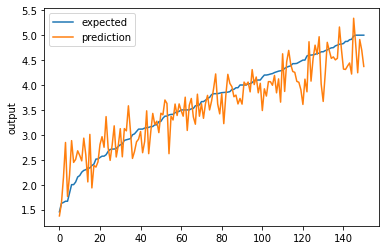

In [19]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))

for i in range(10):
        #print('{}: Stars:{}, -> Predicted:{} for business:{}'.format(i, y_train[i], pred[i], origin.iloc[i]['name']))
        print('{}) \'{}\' rating={}, Predicted rating={}'. format(i+1,df_business.iloc[i]['name'],df_business.iloc[i]['stars'],pred[i]))

print(f'Score (RMSE): {score}')

chart_regression(pred.flatten(), y_test, sort=True)